[Adult-Income-Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset) 

ML Classification Task: Predict whether income of a person exceeds $50K/yr

In [4]:
!mkdir {Data,Imbalanced_Data,Optional_Data}

!wget http://s3.eu-central-1.amazonaws.com/dsceurope2022/1-AdultCensus_Training.csv
!wget http://s3.eu-central-1.amazonaws.com/dsceurope2022/2-AdultCensus_Holdout.csv
!wget http://s3.eu-central-1.amazonaws.com/dsceurope2022/3-AdultCensus_Synthetic.csv
!wget http://s3.eu-central-1.amazonaws.com/dsceurope2022/Optional\ Files/AdultCensus_Original.csv
!mv 1-AdultCensus_Training.csv Data
!mv 2-AdultCensus_Holdout.csv Data
!mv 3-AdultCensus_Synthetic.csv Data
!mv AdultCensus_Original.csv Optional_Data
!ls

mkdir: cannot create directory ‘Data’: File exists
mkdir: cannot create directory ‘Imbalanced_Data’: File exists
mkdir: cannot create directory ‘Optional_Data’: File exists
--2022-11-15 09:38:37--  http://s3.eu-central-1.amazonaws.com/dsceurope2022/1-AdultCensus_Training.csv
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.43
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2815657 (2.7M) [application/octet-stream]
Saving to: ‘1-AdultCensus_Training.csv’

1-AdultCensus_Train 100%[===================>]   2.68M  1.54MB/s    in 1.7s    

2022-11-15 09:38:39 (1.54 MB/s) - ‘1-AdultCensus_Training.csv’ saved [2815657/2815657]

--2022-11-15 09:38:39--  http://s3.eu-central-1.amazonaws.com/dsceurope2022/2-AdultCensus_Holdout.csv
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.43
Connecting to s3.eu-central-1

##Import Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix,confusion_matrix, classification_report

np.random.seed(0)

# [OPTIONAL]: Target Manipulations for fair ML Comparison

1.   Separate original target into target-holdout(20%) and target(80%)
2.   Discard extreme-rare sample (one) from target dataset for fair ML comparison



In [3]:
# Read original target dataset
df = pd.read_csv("./Optional_Data/AdultCensus_Original.csv")
print(df.shape)

# Separate 20% of the target dataset as a holdout
df_1=df.sample(frac=0.2,random_state=5)
print('Holdout dataset (shape: {}) do not have any data with native country as Holand-Netherlands: {}'.format(df_1.shape,df_1[df_1['native.country']=='Holand-Netherlands'].index))
df_1.to_csv('Data/target_holdout.csv',index=False)

# Save remaining 80% of target as a target (with Holand-Netherland in it)
df = df.drop(df_1.index)
print('Target dataset (shape: {}) with native country as Holand-Netherlands: {}'.format(df.shape,df[df['native.country']=='Holand-Netherlands'].index))
df.to_csv('Data/target_after_holdout_separation.csv',index=False)

(32561, 15)
Holdout dataset (shape: (6512, 15)) do not have any data with native country as Holand-Netherlands: Int64Index([], dtype='int64')
Target dataset (shape: (26049, 15)) with native country as Holand-Netherlands: Int64Index([211], dtype='int64')


In [ ]:
# Discard the data sample with Holand-Netherland as a native-country
df = pd.read_csv("Data/target_after_holdout_separation.csv")
df=df.drop(df[df['native.country']=='Holand-Netherlands'].index)
print('After discarding, the new shape: ',df.shape)
df.to_csv('Data/adult.csv',index=False)

After discarding, the new shape:  (26048, 15)


After finishing Target Manipulations, we are ready to synthesise the **adult.csv** in Data folder. After sytnthesising via our website, the generated **adult_syn.csv** should be put inside Data folder for those whom wish to do manually.

#Preprocessing Pipeline for target, target-holdout and synthetic datasets

##Load data and handle missing values

In [ ]:
def preprocess_data(filename):
    df = pd.read_csv(filename)
    # Display the number of records
    print("the number of {} records:{}\n".format(filename, len(df.index)))
    
    # Replace missing values with np.nan
    df = df.applymap(lambda d: np.nan if d=="?" else d)
    
    # Display the information about missing values and the final number of records after deleting missing values
    print("missing value info:\n{}\n".format(df.isnull().sum(axis=0)))
    df = df.dropna(axis=0)
    print("the number of {} records after deleting missing values:{}\n".format(filename, len(df))) 
    return df

df_target = preprocess_data("./Data/1-AdultCensus_Training.csv")
df_holdout = preprocess_data("./Data/2-AdultCensus_Holdout.csv")
df_syn = preprocess_data("./Data/3-AdultCensus_Synthetic.csv")

# Equalize the number of training samples for target and synthetic after deleting missing values
def equalize_sample_size(df1,df2):
    if df1.shape[0]<df2.shape[0]:
      df_syn=df2.sample(n=df1.shape[0],random_state=5)
      df_target=df1
    else:
      df_target=df1.sample(n=df2.shape[0],random_state=5)
      df_syn=df2
    return df_target, df_syn

df_target,df_syn = equalize_sample_size(df_target,df_syn)
print('Target shape: {} , Syn shape: {}'.format(df_target.shape,df_syn.shape))

the number of ./Data/1-AdultCensus_Training.csv records:26048

missing value info:
age                  0
workclass         1467
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1474
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     456
income               0
dtype: int64

the number of ./Data/1-AdultCensus_Training.csv records after deleting missing values:24139

the number of ./Data/2-AdultCensus_Holdout.csv records:6512

missing value info:
age                 0
workclass         369
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation        369
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    127
income              0
dtype: int64

the number of ./Data/2-AdultCensus_Holdo

##Transform columns 

In [ ]:
def convert_data(df):

    # Map income (label) column into numerical
    y=df['income'].map({'<=50K': 0, '>50K': 1})
    df=df.drop('income', axis=1)

    # Transform categorical columns via one-hot encoding while scaling numerical columns 
    categorical_features=[col for col in df.columns if df[col].dtype=='object']
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    numerical_features=[col for col in df.columns if df[col].dtype!='object']
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
        )
    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, numerical_features),
                      ("cat", categorical_transformer, categorical_features),]
                      )
    
    X = preprocessor.fit_transform(df)
    return X,y

X_train_syn, y_train_syn = convert_data(df_syn)
X_train_target, y_train_target = convert_data(df_target)
X_test, y_test = convert_data(df_holdout)

print('Target training data shape:{} , Syn training data shape:{} , Holdout data shape:{} , '.format(X_train_target.shape,X_train_syn.shape,X_test.shape ))

Target training data shape:(24139, 103) , Syn training data shape:(24139, 103) , Holdout data shape:(6022, 103) , 


#Compare ML classification results for target and synthetic data

##Train & Test with Random Forest

### For Target Data

#### Train ML Model

In [ ]:
model = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
#scores = cross_val_score(model, X_train_target, y_train_target, cv=5)
model.fit(X_train_target, y_train_target)

RandomForestClassifier(n_estimators=10, random_state=0)

#### Evaluate ML model

[0 0 0 ... 0 0 0]
Accuracy (Caution): 84.35735636001328
Balanced accuracy:  75.97083745644744


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


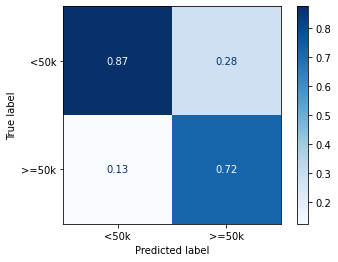

In [ ]:
preds = model.predict(X_test)
print(preds)
print("Accuracy (Caution):", accuracy_score(y_test, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, preds)*100)
plot_confusion_matrix(model, X_test, y_test, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred")

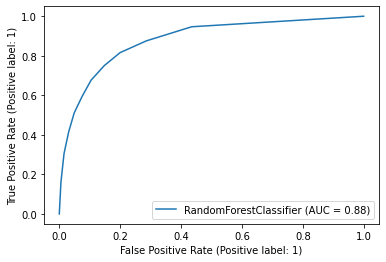

In [ ]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

###For Synthetic Data

####Train ML Model

In [ ]:
model.fit(X_train_syn, y_train_syn)

RandomForestClassifier(n_estimators=10, random_state=0)

####Evaluate ML Model

[0 0 0 ... 0 0 0]
Accuracy (Caution): 84.72268349385587
Balanced accuracy:  75.85044054459557


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


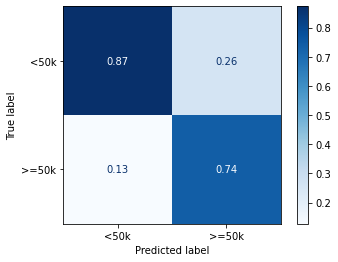

In [ ]:
preds = model.predict(X_test)
print(preds)
print("Accuracy (Caution):", accuracy_score(y_test, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, preds)*100)
plot_confusion_matrix(model, X_test, y_test, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred")

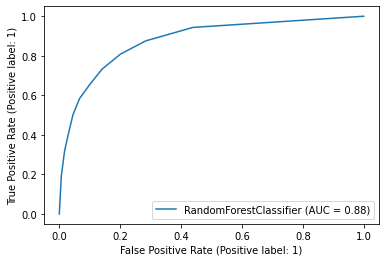

In [ ]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

##Train & Test with SVM

### For Target Data

#### Train ML Model

In [ ]:
model = SVC(kernel='linear', gamma=10)
model.fit(X_train_target, y_train_target)

SVC(gamma=10, kernel='linear')

#### Evaluate ML Model

[0 0 0 ... 0 0 0]
Accuracy (Caution): 85.37030886748589
Balanced accuracy:  76.3935185240182


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


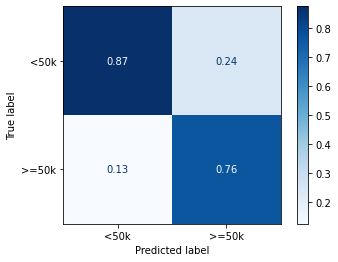

In [ ]:
preds = model.predict(X_test)
print(preds)
print("Accuracy (Caution):", accuracy_score(y_test, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, preds)*100)
plot_confusion_matrix(model, X_test, y_test, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred")

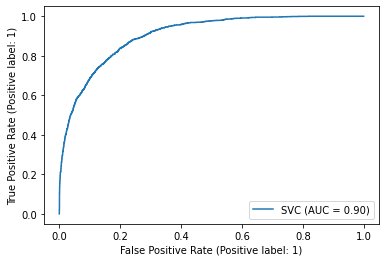

In [ ]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

###For Synthetic Data

####Train ML Model

In [ ]:
model.fit(X_train_syn, y_train_syn)

SVC(gamma=10, kernel='linear')

####Test ML Model

[0 1 0 ... 0 0 0]
Accuracy (Caution): 84.65626037861176
Balanced accuracy:  75.10345403118797


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


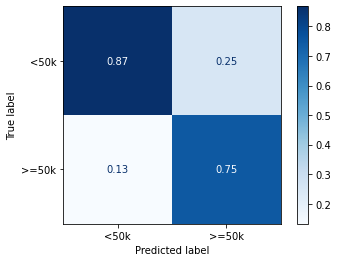

In [ ]:
preds = model.predict(X_test)
print(preds)
print("Accuracy (Caution):", accuracy_score(y_test, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, preds)*100)
plot_confusion_matrix(model, X_test, y_test, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred")

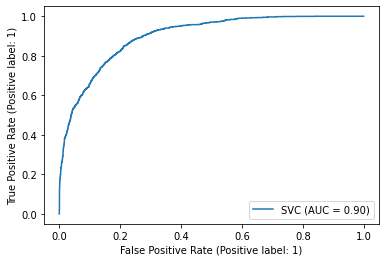

In [ ]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

#Repeat ML Classification Results after Imbalancing the target data

In [ ]:
!mkdir Imbalanced_Data

!wget http://s3.eu-central-1.amazonaws.com/dsceurope2022/5-AdultCensus_ImbalancedTraining.csv
!wget http://s3.eu-central-1.amazonaws.com/dsceurope2022/6-AdultCensus_BalancedSynthetic.csv
!mv 5-AdultCensus_ImbalancedTraining.csv Imbalanced_Data
!mv 6-AdultCensus_BalancedSynthetic.csv Imbalanced_Data

mkdir: cannot create directory ‘Imbalanced_Data’: File exists
--2022-11-15 08:45:17--  http://s3.eu-central-1.amazonaws.com/dsceurope2022/5-AdultCensus_ImbalancedTraining.csv
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.157
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2145776 (2.0M) [application/octet-stream]
Saving to: ‘5-AdultCensus_ImbalancedTraining.csv’

5-AdultCensus_Imbal 100%[===================>]   2.05M  2.71MB/s    in 0.8s    

2022-11-15 08:45:18 (2.71 MB/s) - ‘5-AdultCensus_ImbalancedTraining.csv’ saved [2145776/2145776]

--2022-11-15 08:45:18--  http://s3.eu-central-1.amazonaws.com/dsceurope2022/6-AdultCensus_BalancedSynthetic.csv
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.157
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.157|:80...

## [OPTIONAL] Imbalance the original dataset

In [ ]:
def create_imbalance(filename,target, ratio):
    df=pd.read_csv(filename)
    print("Original target shape: {}\n number of incomes with <=50K: {}\n number of incomes with >50K: {}\n".format(df.shape,
                          len(df[df['income']=='<=50K']), len(df[df['income']=='>50K']))) 
    random.seed(123)
    minor, maj = df[target].value_counts().sort_values().index
    idx_maj = df.index[df[target]==maj].tolist()
    idx_min = df.index[df[target]==minor].tolist()
    number_min = int(len(idx_maj)/(1-ratio)*ratio)
    idx_min = random.sample(idx_min, number_min) 
    df_imb = df.loc[(idx_maj + idx_min),:].sample(frac=1, random_state = 42).reset_index(drop=True)
    return df_imb

df_imbalanced=create_imbalance('./Data/adult.csv','income',0.01)
print("After imbalancing target shape: {}\n number of incomes with <=50K: {}\n number of incomes with >50K: {}\n".format(df_imbalanced.shape,
                          len(df_imbalanced[df_imbalanced['income']=='<=50K']), len(df_imbalanced[df_imbalanced['income']=='>50K']))) 
df_imbalanced.to_csv('Imbalanced_Data/imbalanced_adult.csv',index=False)

Original target shape: (26048, 15)
 number of incomes with <=50K: 19767
 number of incomes with >50K: 6281

After imbalancing target shape: (19966, 15)
 number of incomes with <=50K: 19767
 number of incomes with >50K: 199



##Preprocessing Pipeline for imbalanced target, its synthetic and balanced-synthetic datasets

####Handle missing values

In [ ]:
df_target = preprocess_data("Imbalanced_Data/5-AdultCensus_ImbalancedTraining.csv")
df_syn_balanced = preprocess_data("Imbalanced_Data/6-AdultCensus_BalancedSynthetic.csv")
df_syn_balanced=df_syn_balanced.drop(['Unnamed: 0'], axis=1)

df_target,df_syn_balanced = equalize_sample_size(df_target,df_syn_balanced)
print('Target shape: {} , Syn shape: {}'.format(df_target.shape,df_syn_balanced.shape))

the number of Imbalanced_Data/5-AdultCensus_ImbalancedTraining.csv records:19966

missing value info:
age                  0
workclass         1317
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1324
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     353
income               0
dtype: int64

the number of Imbalanced_Data/5-AdultCensus_ImbalancedTraining.csv records after deleting missing values:18307

the number of Imbalanced_Data/6-AdultCensus_BalancedSynthetic.csv records:15006

missing value info:
Unnamed: 0          0
age                 0
workclass         723
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation        726
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    

In [ ]:
df_holdout.income.value_counts(normalize=True)

<=50K    0.75357
>50K     0.24643
Name: income, dtype: float64

In [ ]:
df_target.income.value_counts(normalize=True)

<=50K    0.989544
>50K     0.010456
Name: income, dtype: float64

In [ ]:
df_syn_balanced.income.value_counts(normalize=True)

>50K     0.515119
<=50K    0.484881
Name: income, dtype: float64

####Transform columns

In [ ]:
X_train_target, y_train_target = convert_data(df_target)
X_train_syn_balanced, y_train_syn_balanced = convert_data(df_syn_balanced)

In [ ]:
X_train_target.shape

(14154, 103)

In [ ]:
X_train_syn_balanced.shape

(14154, 103)

##Compare ML Classification Results

###Random Forest

####Train ML Model with imbalanced target and Evaluate



[0 0 0 ... 0 0 0]
Accuracy (Caution): 75.53968781135836
Balanced accuracy:  50.46131855704271


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


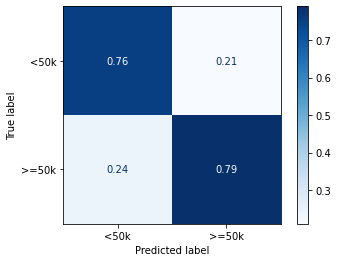

In [ ]:
model = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
model.fit(X_train_target, y_train_target)

preds = model.predict(X_test)
print(preds)
print("Accuracy (Caution):", accuracy_score(y_test, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, preds)*100)
plot_confusion_matrix(model, X_test, y_test, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred")

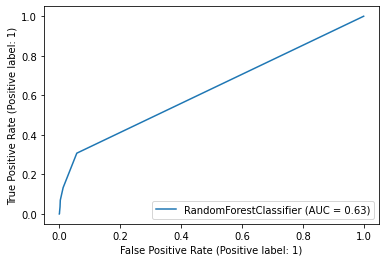

In [ ]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

####Train ML Model with balanced synthetic dataset and Evaluate



[0 1 0 ... 1 0 1]
Accuracy (Caution): 78.14679508468947
Balanced accuracy:  78.56177662363581


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


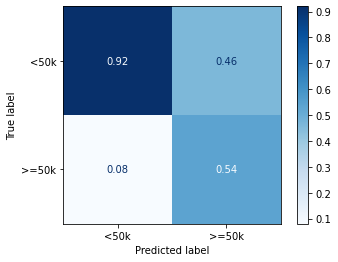

In [ ]:
model.fit(X_train_syn_balanced, y_train_syn_balanced)

preds = model.predict(X_test)
print(preds)
print("Accuracy (Caution):", accuracy_score(y_test, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, preds)*100)
plot_confusion_matrix(model, X_test, y_test, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred")

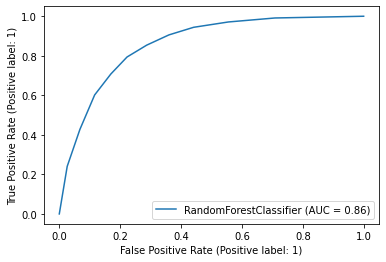

In [ ]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()